# 1. Setup and Library Imports
This cell imports all necessary libraries from pandas, numpy, and scikit-learn. 

It also sets global configuration variables and suppresses warnings for cleaner output.


In [2]:
## Markdown Cell: Setup and Library Imports

# Import core libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
# Import supervised models and metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

# Import unsupervised models and metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
import warnings
from sklearn.metrics import  accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
warnings.filterwarnings('ignore') 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import joblib
import os

# 2. Data Loading and Feature Identification

This cell loads the cleaned dataset, separates the features ($\mathbf{X}$) from the target variable ($\mathbf{y}$), and identifies the categorical and numerical columns, which is essential for defining the preprocessing steps.

In [3]:

# --- CONFIGURATION ---
# Load the data
stroke_data = pd.read_csv('../Data/stroke_data_cleaned.csv')
K_CLUSTERS = 2 # Setting k=2 for clustering (Stroke/No-Stroke hypothesis)

# Exclude 'id' and separate features (X) and target (y)
X = stroke_data.drop(['stroke', 'id'], axis=1)
y = stroke_data['stroke']

# Identify column types
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Total Features: {X.shape[1]}")
print(f"Numerical Columns: {numerical_cols}")
print(f"Categorical Columns: {categorical_cols}")
print(f"\nTarget imbalance (Stroke=1): {y.mean():.4f}")

Total Features: 10
Numerical Columns: ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
Categorical Columns: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

Target imbalance (Stroke=1): 0.0487


# 3. Data Splitting and Preprocessing Pipeline

In [4]:


# Split data (80% Train, 20% Test, stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create preprocessing steps
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'
)

# Apply preprocessing to transform the data (Fit on training, Transform on both)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Data preprocessing complete.")

Data preprocessing complete.


# 4. Supervised Learning: Training and Evaluation

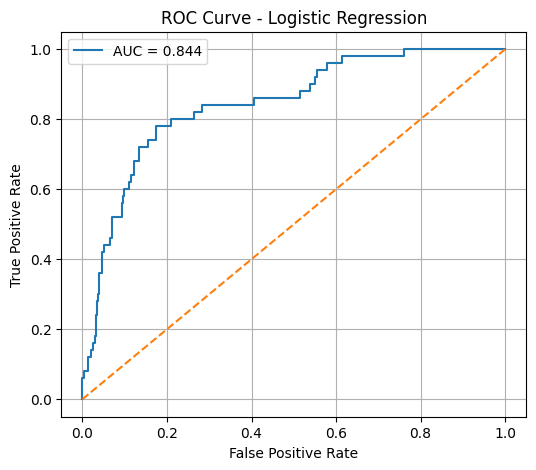

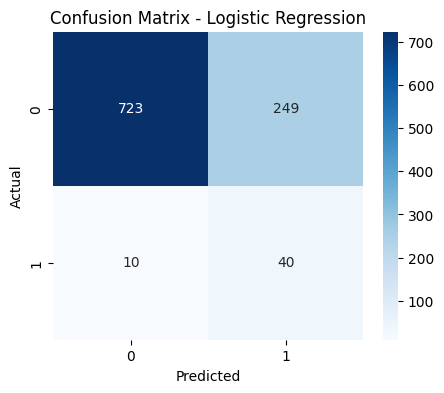

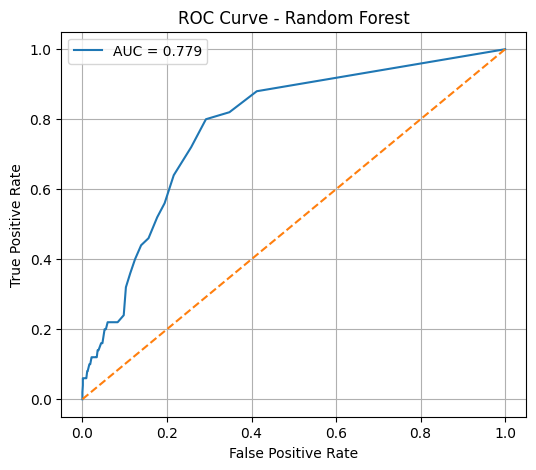

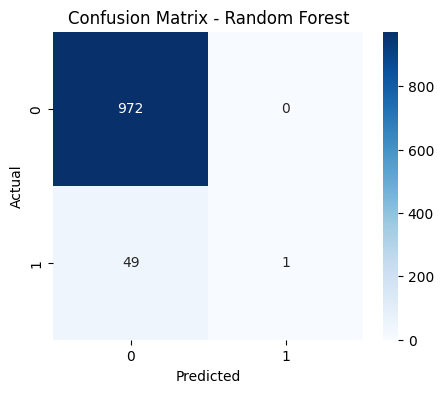

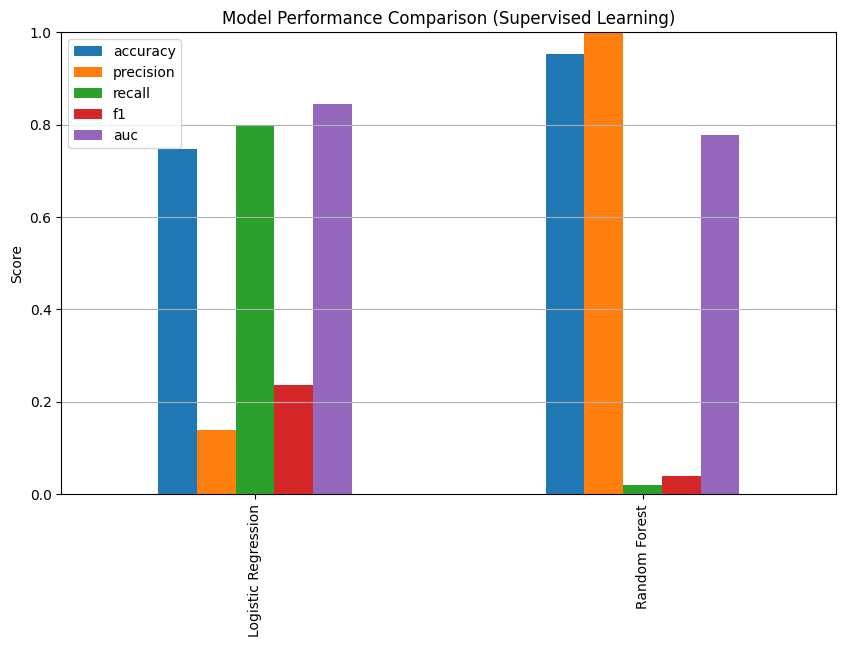

In [5]:
models = {
    "Logistic Regression": LogisticRegression(
        random_state=42, solver='liblinear', class_weight='balanced', max_iter=1000
    ),
    "Random Forest": RandomForestClassifier(
        random_state=42, class_weight='balanced', n_estimators=100
    )
}

# Store outputs to avoid retraining
model_outputs = {}

for name, model in models.items():

    # Train once
    model.fit(X_train_processed, y_train)

    # Predict
    y_pred = model.predict(X_test_processed)
    y_proba = model.predict_proba(X_test_processed)[:, 1]

    model_outputs[name] = {
        "model": model,
        "y_pred": y_pred,
        "y_proba": y_proba
    }

    # ===== ROC Curve =====
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.title(f"ROC Curve - {name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ===== Confusion Matrix =====
    conf_mat = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()



# ----------------------------------------------
# BAR PLOT — METRIC COMPARISON (explicit functions)
# ----------------------------------------------

metric_summary = {}

for name, output in model_outputs.items():

    y_pred = output["y_pred"]
    y_proba = output["y_proba"]

    metric_summary[name] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "auc": roc_auc_score(y_test, y_proba)
    }

metric_df = pd.DataFrame(metric_summary).T

metric_df[["accuracy", "precision", "recall", "f1", "auc"]].plot(
    kind="bar", figsize=(10, 6)
)

plt.title("Model Performance Comparison (Supervised Learning)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

In [7]:
# -----------------------------------------
# CLEAN METRICS TABLE (Consistent & Correct)
# -----------------------------------------

table_data = []

for name, output in model_outputs.items():

    y_pred = output["y_pred"]
    y_proba = output["y_proba"]

    table_data.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision (Class 1)": precision_score(y_test, y_pred, zero_division=0),
        "Recall (Class 1)": recall_score(y_test, y_pred, zero_division=0),
        "F1-score (Class 1)": f1_score(y_test, y_pred, zero_division=0),
        "ROC-AUC": roc_auc_score(y_test, y_proba)
    })

# Convert to DataFrame
results_df = pd.DataFrame(table_data).round(3)

# Display formatted table
print("\n=== Summary Performance Table ===")
display(
    results_df.style.set_table_styles([
        {'selector': 'th', 'props': [('font-size', '12pt'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('font-size', '11pt')]}
    ]).set_properties(**{'text-align': 'center'})
)



=== Summary Performance Table ===


,Model,Accuracy,Precision (Class 1),Recall (Class 1),F1-score (Class 1),ROC-AUC
0,Logistic Regression,0.747000,0.138000,0.800000,0.236000,0.844000
1,Random Forest,0.952000,1.000000,0.020000,0.039000,0.779000


# 5. Unsupervised Learning: Clustering


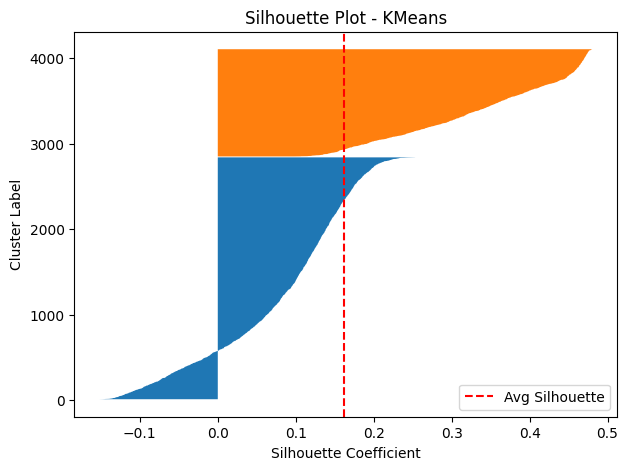

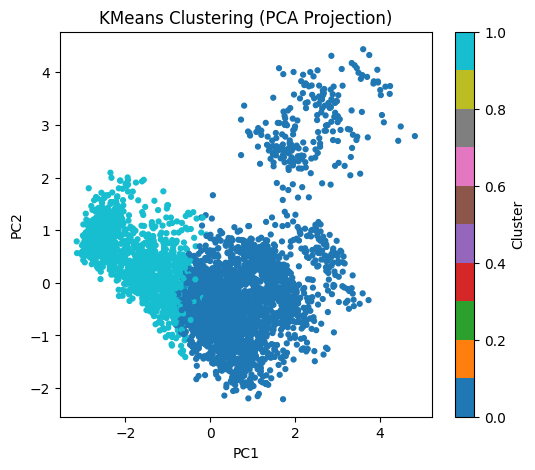

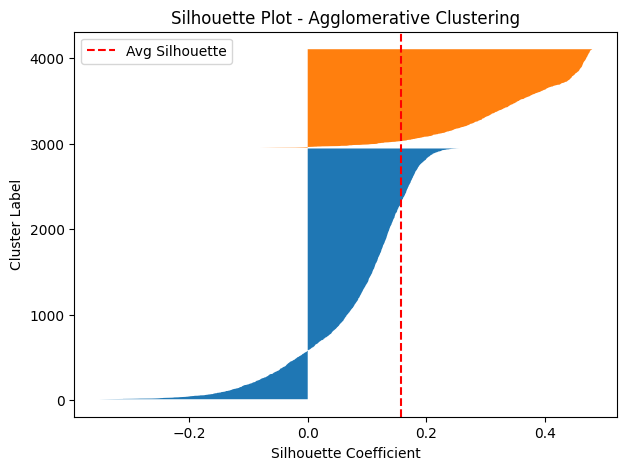

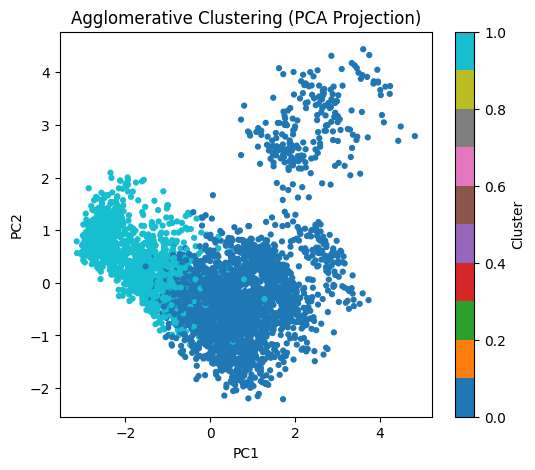

In [8]:
# ----------------------------------------------
# UNSUPERVISED LEARNING — PLOTS ONLY
# ----------------------------------------------

# -----------------------------
# Model 1: k-Means Clustering
# -----------------------------
kmeans = KMeans(n_clusters=K_CLUSTERS, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_train_processed)
silhouette_avg_kmeans = silhouette_score(X_train_processed, kmeans_labels)

# --- Silhouette Plot for KMeans ---
sample_sil = silhouette_samples(X_train_processed, kmeans_labels)
plt.figure(figsize=(7, 5))
plt.title("Silhouette Plot - KMeans")

y_lower = 10
for i in range(K_CLUSTERS):
    ith_silhouette = sample_sil[kmeans_labels == i]
    ith_silhouette.sort()
    size_i = len(ith_silhouette)
    y_upper = y_lower + size_i
    
    plt.fill_betweenx(
        np.arange(y_lower, y_upper),
        0, ith_silhouette
    )
    
    y_lower = y_upper + 10

plt.axvline(silhouette_avg_kmeans, color="red", linestyle="--", label="Avg Silhouette")
plt.xlabel("Silhouette Coefficient")
plt.ylabel("Cluster Label")
plt.legend()
plt.show()

# --- PCA Visualization of Clusters (KMeans) ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_processed)

plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap="tab10", s=12)
plt.title("KMeans Clustering (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()


# -----------------------------
# Model 2: Agglomerative Clustering
# -----------------------------
agg = AgglomerativeClustering(n_clusters=K_CLUSTERS)
agg_labels = agg.fit_predict(X_train_processed)
silhouette_avg_agg = silhouette_score(X_train_processed, agg_labels)

# --- Silhouette Plot for Agglomerative ---
sample_sil_agg = silhouette_samples(X_train_processed, agg_labels)
plt.figure(figsize=(7, 5))
plt.title("Silhouette Plot - Agglomerative Clustering")

y_lower = 10
for i in range(K_CLUSTERS):
    ith_silhouette = sample_sil_agg[agg_labels == i]
    ith_silhouette.sort()
    size_i = len(ith_silhouette)
    y_upper = y_lower + size_i
    
    plt.fill_betweenx(
        np.arange(y_lower, y_upper),
        0, ith_silhouette
    )
    
    y_lower = y_upper + 10

plt.axvline(silhouette_avg_agg, color="red", linestyle="--", label="Avg Silhouette")
plt.xlabel("Silhouette Coefficient")
plt.ylabel("Cluster Label")
plt.legend()
plt.show()

# --- PCA Visualization of Agglomerative ---
plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=agg_labels, cmap="tab10", s=12)
plt.title("Agglomerative Clustering (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()


In [9]:
# ------------------------------------------------------
# SUMMARY TABLE FOR CLUSTERING MODELS
# ------------------------------------------------------

clustering_results = {
    "KMeans": {
        "Silhouette Score": silhouette_avg_kmeans,
    },
    "Agglomerative": {
        "Silhouette Score": silhouette_avg_agg,
    }
}

clustering_df = pd.DataFrame(clustering_results).T
clustering_df = clustering_df.round(4)

print("\n--- Clustering Model Comparison Table ---")
display(clustering_df.style.set_caption("Clustering Performance Summary")
                           .set_properties(**{'text-align': 'center'})
                           .set_table_styles([dict(selector='th', props=[('text-align', 'center')])]))



--- Clustering Model Comparison Table ---


,Silhouette Score
KMeans,0.161700
Agglomerative,0.156800


# 6-Logistic Regression Hyperparameter Tuning (Grid Search)

In [10]:
log_reg = LogisticRegression(
    random_state=42,
    solver="liblinear",
    class_weight="balanced",
    max_iter=1000
)

log_reg_param_grid = {
    "penalty": ["l1", "l2"],
    "C": [0.001, 0.01, 0.1, 1, 10, 100]
}

log_reg_grid = GridSearchCV(
    estimator=log_reg,
    param_grid=log_reg_param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=1
)

log_reg_grid.fit(X_train_processed, y_train)

print("=== Logistic Regression Tuning Results ===")
print("Best Parameters:", log_reg_grid.best_params_)
print("Best CV ROC-AUC:", log_reg_grid.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


=== Logistic Regression Tuning Results ===
Best Parameters: {'C': 0.01, 'penalty': 'l1'}
Best CV ROC-AUC: 0.8419098751071757


# 7-Random Forest Hyperparameter Tuning (Random Search)

In [11]:
rf = RandomForestClassifier(
    random_state=42,
    class_weight="balanced"
)

rf_param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [None, 5, 10, 20, 30, 50],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 8],
    "max_features": ["sqrt", "log2", None]
}

rf_rand = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_dist,
    n_iter=25,
    scoring="roc_auc",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_rand.fit(X_train_processed, y_train)

print("=== Random Forest Tuning Results ===")
print("Best Parameters:", rf_rand.best_params_)
print("Best CV ROC-AUC:", rf_rand.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
=== Random Forest Tuning Results ===
Best Parameters: {'n_estimators': 500, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 5}
Best CV ROC-AUC: 0.8373398091232283


# Results after tunning models

In [12]:
tuned_models = {
    "Logistic Regression (Tuned)": log_reg_grid.best_estimator_,
    "Random Forest (Tuned)": rf_rand.best_estimator_
}

comparison_results = []

for name, model in tuned_models.items():
    y_pred = model.predict(X_test_processed)
    y_proba = model.predict_proba(X_test_processed)[:, 1]

    comparison_results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision (Class 1)": precision_score(y_test, y_pred, zero_division=0),
        "Recall (Class 1)": recall_score(y_test, y_pred, zero_division=0),
        "F1-score (Class 1)": f1_score(y_test, y_pred, zero_division=0),
        "ROC-AUC": roc_auc_score(y_test, y_proba)
    })

comparison_df = pd.DataFrame(comparison_results).round(3)

print("\n=== Tuned Model Performance Comparison ===")
display(
    comparison_df.style
    .set_table_styles([
        {'selector': 'th', 'props': [('font-size', '12pt'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('font-size', '11pt')]}
    ])
    .set_properties(**{'text-align': 'center'})
)


=== Tuned Model Performance Comparison ===


,Model,Accuracy,Precision (Class 1),Recall (Class 1),F1-score (Class 1),ROC-AUC
0,Logistic Regression (Tuned),0.705000,0.125000,0.840000,0.218000,0.841000
1,Random Forest (Tuned),0.782000,0.161000,0.820000,0.269000,0.846000


# Best Final Model


In [13]:

best_index = comparison_df["Recall (Class 1)"].idxmax()
final_model_name = comparison_df.loc[best_index, "Model"]
final_model = tuned_models[final_model_name]

print("=== FINAL SELECTED MODEL ===")
print("Model:", final_model_name)
print("\nBest Hyperparameters:")

if "Logistic" in final_model_name:
    print(log_reg_grid.best_params_)
else:
    print(rf_rand.best_params_)

=== FINAL SELECTED MODEL ===
Model: Logistic Regression (Tuned)

Best Hyperparameters:
{'C': 0.01, 'penalty': 'l1'}


# Code to save Model as Pkl

In [14]:
# ---- EDIT THIS PATH TO WHERE YOU WANT TO SAVE THE MODEL ----
save_dir = "../Models/" 
# -------------------------------------------------------------

# Create directory if it does not exist
os.makedirs(save_dir, exist_ok=True)

# Clean file name
clean_name = final_model_name.replace(" ", "_").replace("(", "").replace(")", "")
file_path = os.path.join(save_dir, f"{clean_name}.pkl")

# Save model
joblib.dump(final_model, file_path)

print(f"Final optimized model saved at:\n{file_path}")

Final optimized model saved at:
../Models/Logistic_Regression_Tuned.pkl
